This notebook plays with different encoding ideas.
The dictionary `bits` contains functions that map encoded value to number of bits needed to represent it using the given encoding.

`total_bits` calculates how many bits on average are necessary to encode values from geometric distribution with given parameter, `relative_bits` calculates average relative efficiency, compared to a non-prefix binary encoding.

`optimal_rice` is a Golomb-Rice encoding tries multiple `k` parameters and choses the one producing shortest output.
`noisy_optimal_rice` simulates inaccuracy of a (hypothetical) adaptive scheme that tries to estimate the `k` parameter for Golomb-Rice encoding.

`vlq4` is a variation on the [variable length quantity](https://en.wikipedia.org/wiki/Variable-length_quantity), where the block size is 4 bits (3 bits of data + 1 bit continuation flag) instead of 8 bits.

`biased_gamma` stores `k` less bits of the unary encoded length. Shortest record is `k + 1` bits long.

`gammaX` encodes `k` bits of the output as a binary number and the rest using Elias gamma encoding.

In [1]:
import inspect
import numpy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200

In [2]:
def geometric_pmf(p, i):
    return (1 - p)**i * p

In [3]:
def binary(x):
    """ Number of bits needed to write x in binary (non-prefix code) """
    return numpy.floor(numpy.log2(numpy.where(x == 0, 1, 2 * x)))

In [4]:
def rice(x, k):
    return ((x - 1) // 2**k) + 1 + k

def _optimal_rice_k(x, weights):
    k = 0
    best = numpy.sum(rice(x, 0) * weights, axis=0)
    for i in range(1, 20):
        encoded = numpy.sum(rice(x, i) * weights, axis=0)
        selector = encoded < best
        k = numpy.where(selector, i, k)
        best = numpy.where(selector, encoded, best)
    return k

def optimal_rice(x, weights):
    return rice(x, _optimal_rice_k(x, weights))
    
def noisy_optimal_rice(x, weights):
    k = _optimal_rice_k(x, weights)
    noise = numpy.random.default_rng().integers(-1, 2, x.shape)
    return rice(x, numpy.maximum(k + noise, 0))
    

In [5]:
def gamma(x):
    return 2 * binary(x) - 1

def delta(x):
    n = binary(x)
    return gamma(n) + n - 1

In [6]:
def biased_gamma(x, k):
    xx = x - 1
    return numpy.where(xx < 2**k, k + 1, 2 * binary(xx) - k)

In [7]:
def gammaX(x, k):
    return k + gamma(((x - 1) >> k) + 1)

In [8]:
def vlq(x, k):
    return k * numpy.ceil(binary(x) / (k - 1))

In [9]:
bits = {
    "(optimal rice)": optimal_rice,
    "noisy optimal rice": noisy_optimal_rice,
    #"gamma": gamma,
    #"delta": delta,
    "vlq4": lambda x: vlq(x, 4),
    #"vlq": lambda x: vlq(x, 8),
    #"biased_gamma1": lambda x: biased_gamma(x, 1),
    "biased_gamma2": lambda x: biased_gamma(x, 2),
    "biased_gamma3": lambda x: biased_gamma(x, 3),
    "gammaX1": lambda x: gammaX(x, 1),
    "gammaX2": lambda x: gammaX(x, 2),
    "gammaX3": lambda x: gammaX(x, 3),
}

In [10]:
def plot_encodings(xs, fun, separate=False, ylim=None):
    for name, encoding in bits.items():
        values = fun(encoding, xs)
        kwargs = {}
        if "noisy" in name:
            kwargs["linewidth"] = 0.5
        else:
            kwargs["linewidth"] = 1
        plt.plot(xs, values, label=name, **kwargs)
        
        if ylim is not None:
            plt.ylim(ylim)
        
        plt.legend()
        plt.semilogx(base=2)
        plt.grid()
        
        if separate:
            plt.show()
        
    if not separate:
        plt.legend()
        plt.semilogx(base=2)
        plt.grid()
        plt.show()

In [11]:
def encoding_wrapper(encoding, xs, weights):
    if "weights" in inspect.signature(encoding).parameters:
        return encoding(xs, weights=weights)
    else:
        return encoding(xs)

In [12]:
def total_bits(encoding, mean_lengths):
    p = 1/mean_lengths
    xs = numpy.arange(1, 10000)
    p, xs = numpy.meshgrid(p, xs)
    
    #a = geometric_pmf(p, xs) * encoding(xs)
    probabilities = geometric_pmf(p, xs)
    
    bit_lengths = encoding_wrapper(encoding, xs, probabilities)
        
    expected_bits = numpy.sum(probabilities * bit_lengths, axis=0) / numpy.sum(probabilities, axis=0)
    
    return expected_bits

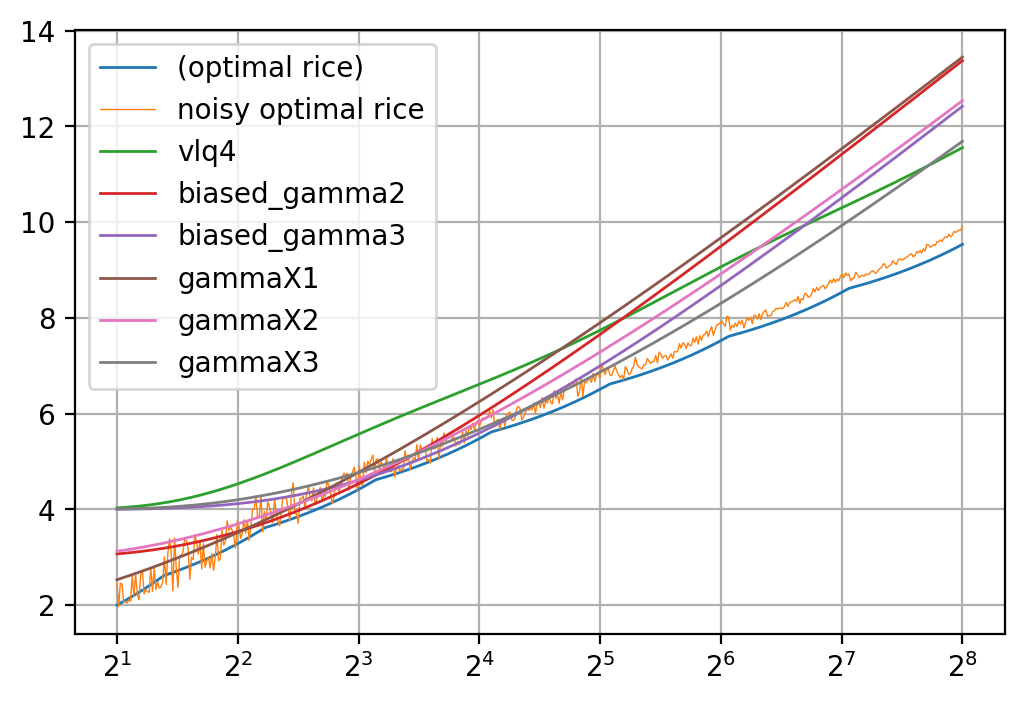

In [13]:
plot_encodings(numpy.logspace(1, 8, 500, base=2), total_bits)
    

In [14]:
def relative_bits(encoding, mean_lengths):
    p = 1/mean_lengths
    xs = numpy.arange(1, 10000)
    p, xs = numpy.meshgrid(p, xs)
    
    probabilities = geometric_pmf(p, xs)
    encoded_bit_lengths = encoding_wrapper(encoding, xs, probabilities)
    optimal_bit_lengths = binary(xs - 1)
    
    expected_bits = numpy.sum(probabilities * encoded_bit_lengths, axis=0)
    optimal_expected_bits = numpy.sum(probabilities * optimal_bit_lengths, axis=0)
        
    relative_bits = expected_bits / optimal_expected_bits - 1
    
    return relative_bits

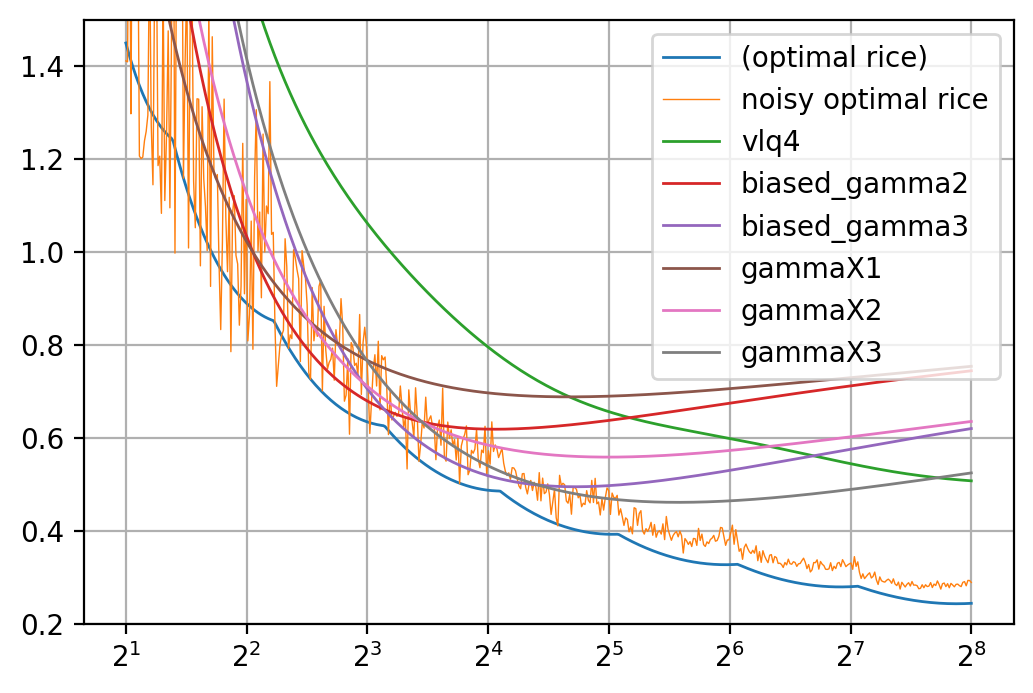

In [15]:
plot_encodings(numpy.logspace(1, 8, 500, base=2), relative_bits, ylim=[0.2, 1.5])


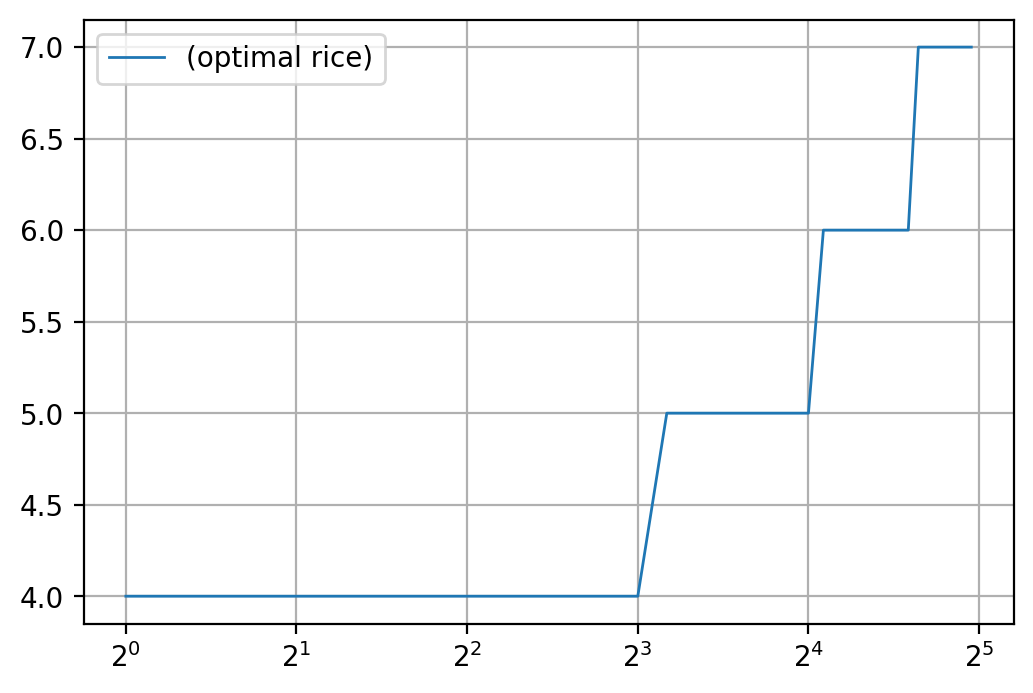

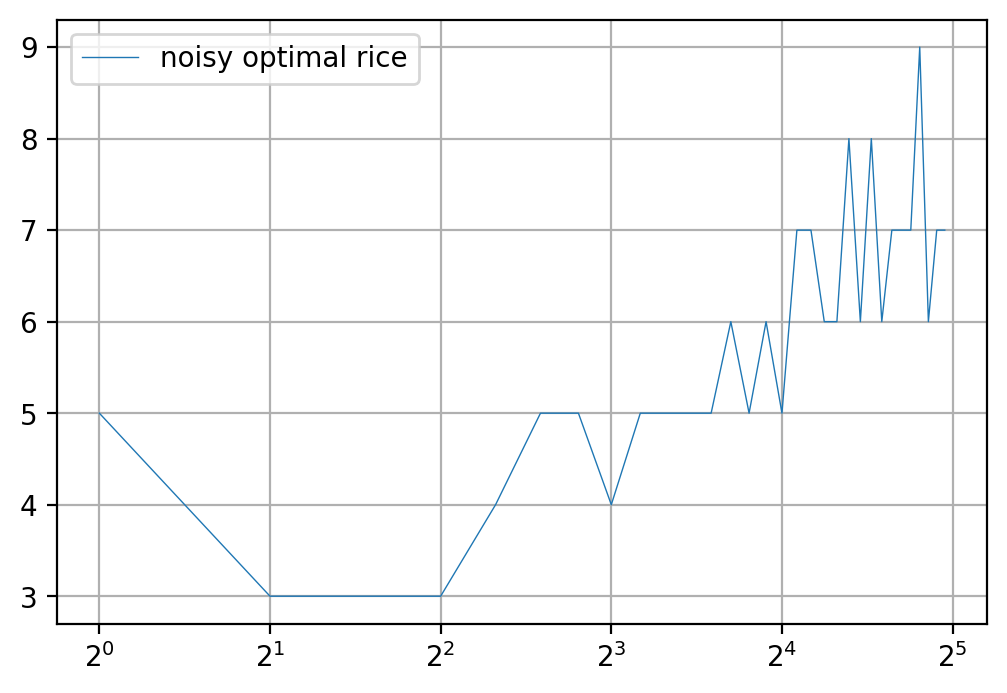

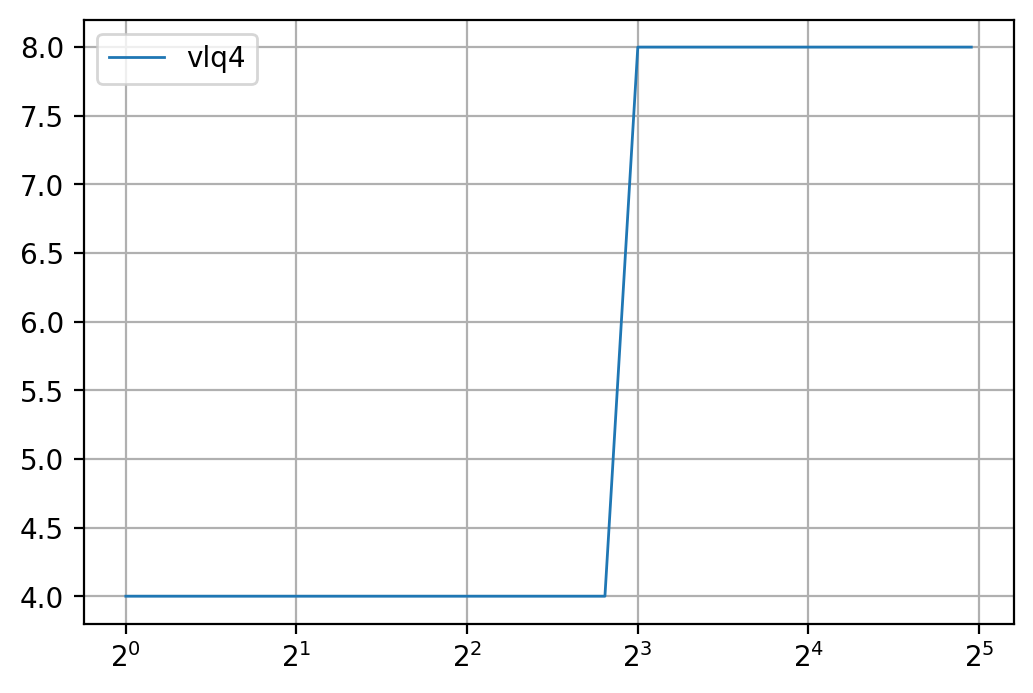

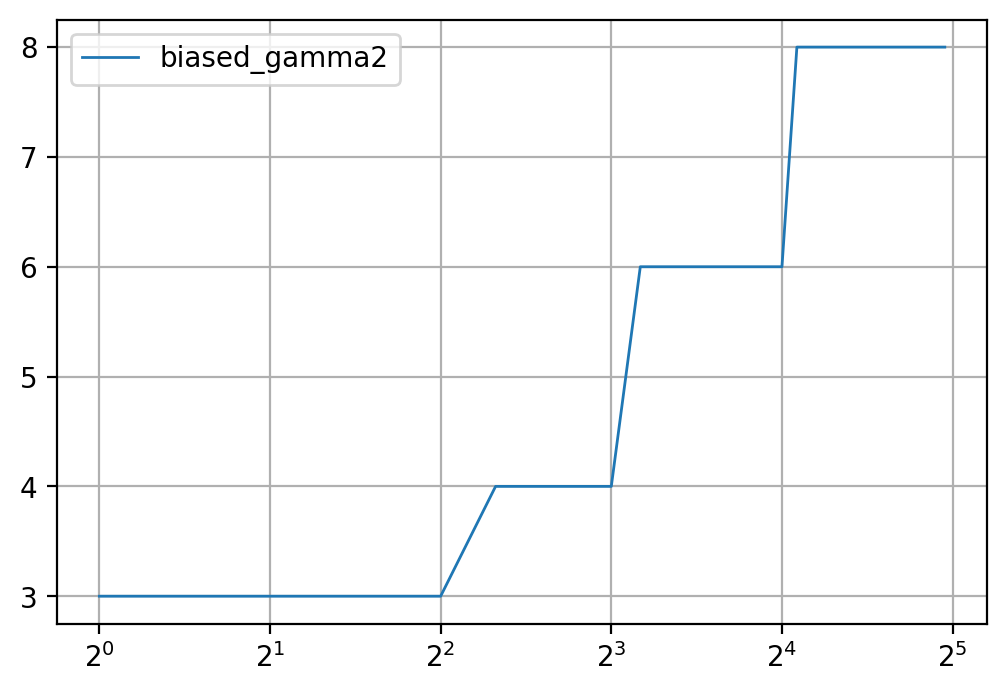

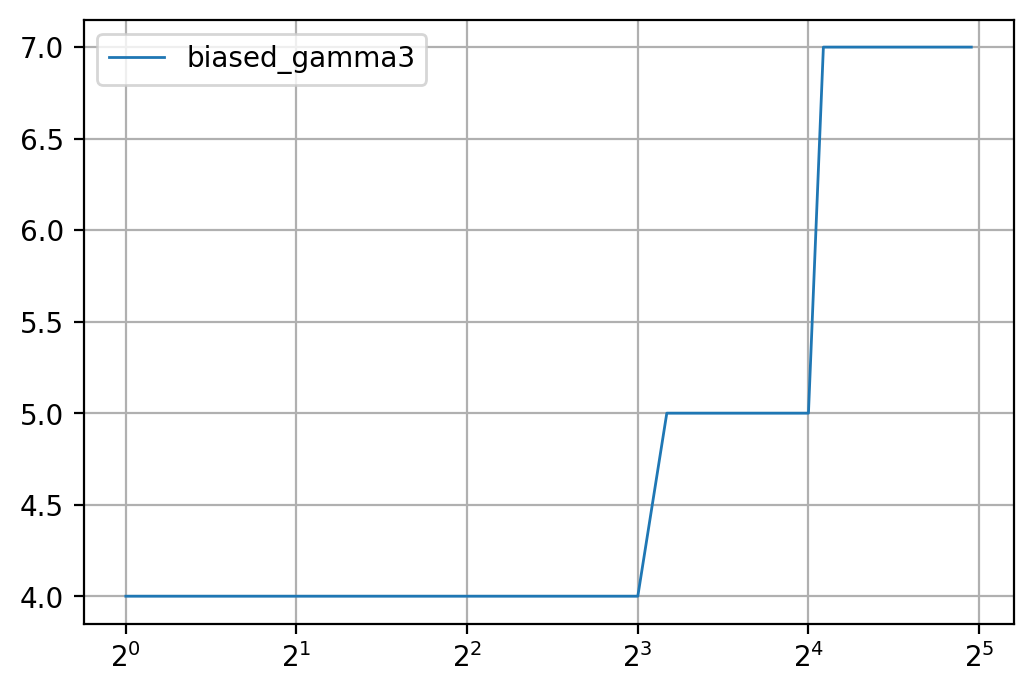

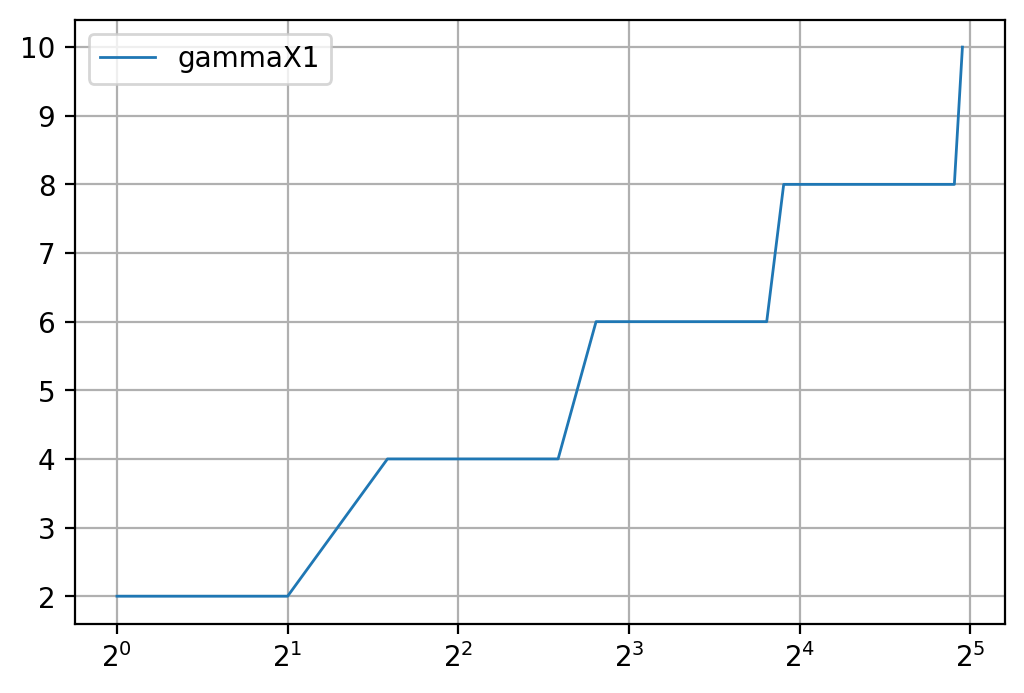

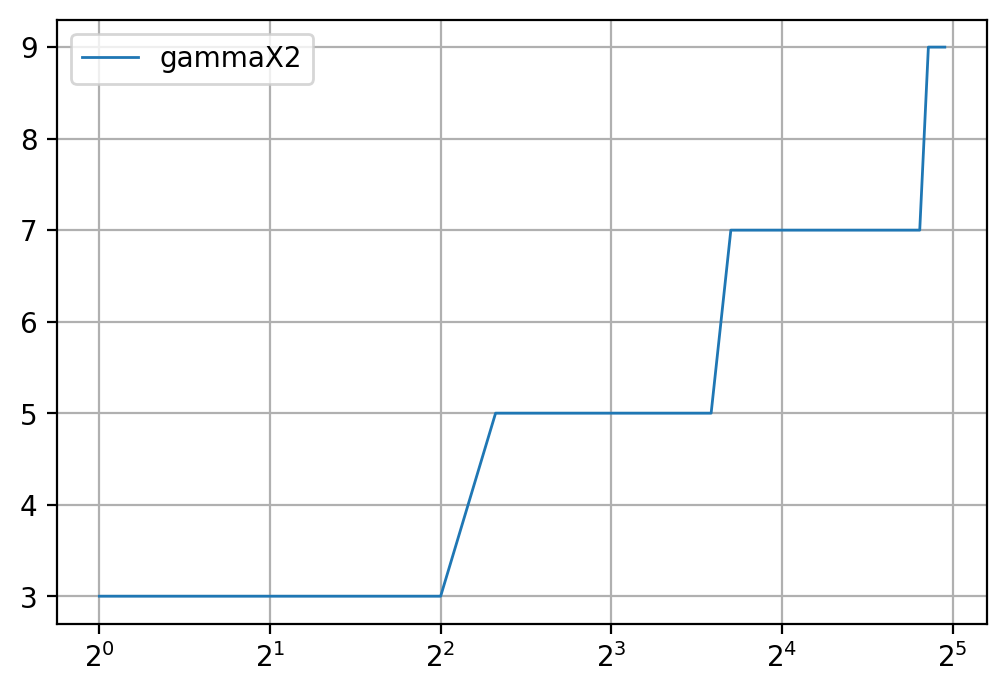

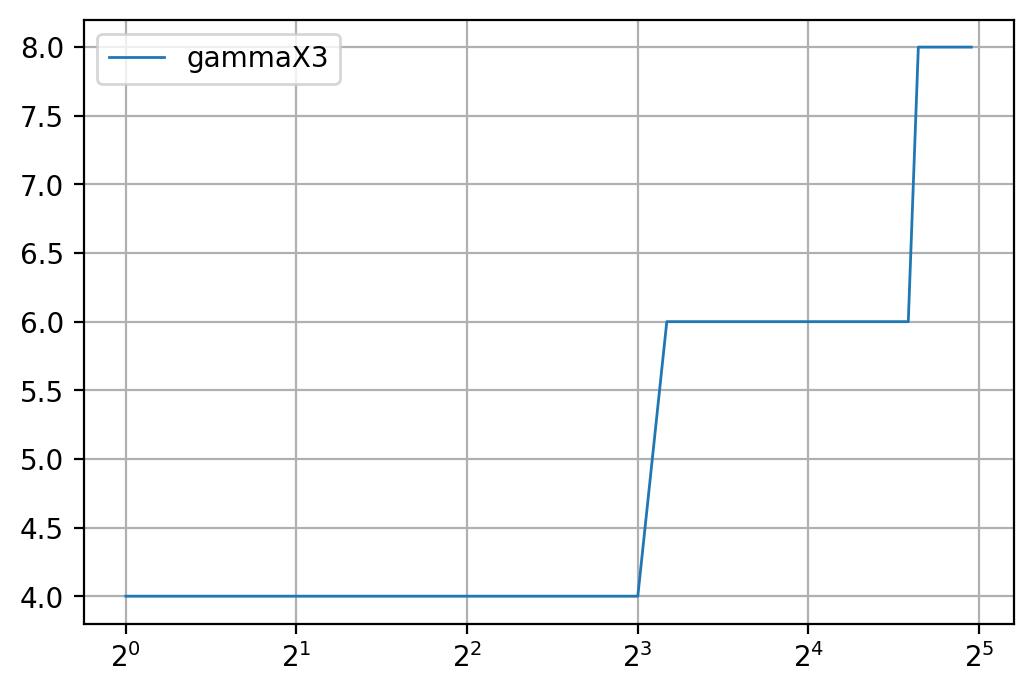

In [16]:
plot_encodings(numpy.arange(1, 32), lambda e, x: encoding_wrapper(e, x, 1), separate=True)

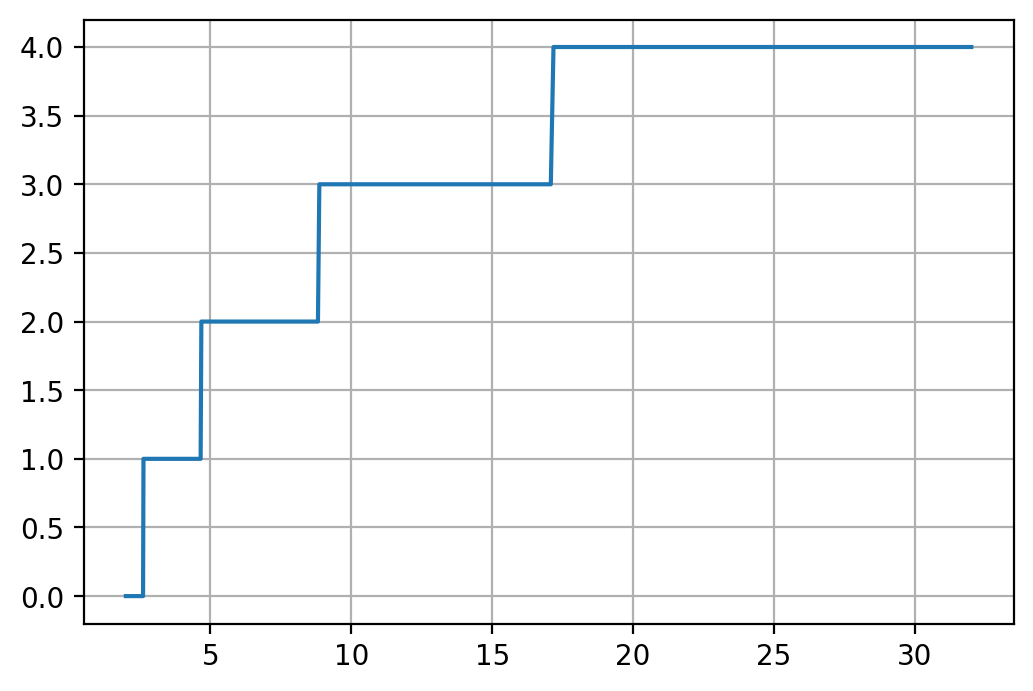

In [17]:
mean_lengths = numpy.logspace(1, 5, 500, base=2)
p = 1/mean_lengths
xs = numpy.arange(1, 10000)
p, xs = numpy.meshgrid(p, xs)

probabilities = geometric_pmf(p, xs)

ks = _optimal_rice_k(xs, probabilities)

plt.plot(mean_lengths, ks)
plt.grid()
plt.show()